# Dauphine PSL - Master IASD app

Object Detection

- Lab duration: 1.30h

- Goals: training an object detection model - FasterRCNN using torchvision implementation. Validation of the model based on mAP



## Loading the data and the required packages

In [ ]:
import os
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

os.mkdir("data")
os.mkdir("data/TP4")

!cd data/TP4
!curl -L -s -o car_object_detection.zip 'https://drive.google.com/uc?id=1POA7yrjHy__ZcvH2cSpzaYDZq473GsCh&confirm=t'
!unzip car_object_detection.zip

# Install pycocotools
!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI
!python setup.py build_ext install
!cd ..
!cd ..

!# Install torchvision useful functions
!git clone https://github.com/pytorch/vision.git
!cd vision
!git checkout v0.3.0


!cp vision/references/detection/utils.py /content
!cp vision/references/detection/transforms.py /content
!cp vision/references/detection/coco_eval.py /content
!cp vision/references/detection/engine.py /content
!cp vision/references/detection/coco_utils.py /content

cuda
Archive:  car_object_detection.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of car_object_detection.zip or
        car_object_detection.zip.zip, and cannot find car_object_detection.zip.ZIP, period.
Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 7.62 MiB/s, done.
Resolving deltas: 100% (576/576), done.
python3: can't open file '/content/setup.py': [Errno 2] No such file or directory
Cloning into 'vision'...
remote: Enumerating objects: 502454, done.
remote: Counting objects: 100% (16064/16064), done.
remote: Compressing objects: 100% (792/792), done.
remote: Total 502454 (delta 15266), reused 16009

In [ ]:
import pandas as pd

df = pd.read_csv('data/train_solution_bounding_boxes (1).csv')
df

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


### a. Read the dataset and split into train, validation.

Read the csv file and only use the image that have a bounding box.



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

path_to_images = "data/training_images"
samples = df.image.tolist()
#list(sorted(os.listdir(os.path.join(path_to_images))))

training_files, validation_files, _, _ = train_test_split(samples, np.zeros(len(samples)), test_size=0.2, random_state=42)

### b. Create your custom dataset class.

This class shoud implement:

- `__getitem__(self, image_id)`: this function should return a PIL image and a `target` dictionary containing relevant information about that image.
- `self.img_dict`: a dictionary that maps the id of an image to relevant info about it (path of the image, bounding box coordinates, class). __Warning__: We only use images with cars. We discarded the images without a car.
- `self.class_names`: a dictionary that maps the names to labels read by the model.
- `__len__(self)`: this function should return the length of the dataset.
- `load_image(self, image_id`: this function should return the RGB image indicated by the `ìmage_id`
- `__init__(self, img_list, cls_names, bboxes, transforms, name)` : the class constructor in which you should implement `self.img_dict`.

One important detail is that the constructor of the dataset should have the variable `transforms`, which is set inside the constructor. It should then be used in `__getitem__(self, image_id)` as shown below.

Hint: you can use the following torchvision tutorial for defining the `Dataset` : https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [ ]:
import os
import numpy as np
import torch
from PIL import Image



class CarDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_images, files, path_to_csv, transforms):

        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.path_to_images = path_to_images
        self.imgs = files
        self.df = pd.read_csv(path_to_csv)

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.path_to_images, self.imgs[idx])

        img = Image.open(img_path).convert("RGB")

        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background

        # get bounding box coordinates for each mask
        num_objs = self.df[self.df.image == self.imgs[idx]].shape[0]

        sub_df = self.df[self.df.image == self.imgs[idx]]

        boxes = []
        for i in range(num_objs):

            xmin = int(sub_df.xmin.iloc[i])
            xmax = int(sub_df.xmax.iloc[i])
            ymin = int(sub_df.ymin.iloc[i])
            ymax = int(sub_df.ymax.iloc[i])

            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        if len(boxes) > 0 :
          area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
          area = 0
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        img = img / 255.

        return img, target

    def __len__(self):
        return len(self.imgs)

### c. Data augmentation

The `get_transform(train)` function applies random flips to the images during training.

In order to flip an image as well as the corresponding bounding box coordinates, a `RandomHorizontalFlip(object)` class was implemented.

If you wish, you can implement your own data augmentation class to perform vertical flips or rotations.



    class RandomHorizontalFlip(object):

        def __init__(self, prob):
            self.prob = prob

        def __call__(self, image, target):
            if random.random() < self.prob:
                height, width = image.shape[-2:]
                image = image.flip(-1)
                bbox = target["boxes"]
                bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
                target["boxes"] = bbox

                if "masks" in target:
                    target["masks"] = target["masks"].flip(-1)
                if "keypoints" in target:
                    keypoints = target["keypoints"]
                    keypoints = _flip_coco_person_keypoints(keypoints, width)
                    target["keypoints"] = keypoints
            return image, target

In [ ]:
import transforms as T


def get_transform(train:bool):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ToDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

train_transforms = get_transform(train=True)
val_transforms = get_transform(train=False)

### d. Instantiate train and validation

- Create your train, validation and test sets using the `CarDataset` class.
- How imbalanced is your dataset ?

In [ ]:
train_dataset = CarDataset(path_to_images="data/training_images",
                           files=training_files,
                           path_to_csv="data/train_solution_bounding_boxes (1).csv",
                           transforms=train_transforms)

validation_dataset = CarDataset(path_to_images="data/training_images",
                           files=validation_files,
                           path_to_csv="data/train_solution_bounding_boxes (1).csv",
                           transforms=val_transforms)

print("Number of images in training set: {}".format(len(train_dataset)))
print("Number of images in validation set: {}".format(len(validation_dataset)))

Number of images in training set: 447
Number of images in validation set: 112


### e. Visualize some images with their bounding boxes

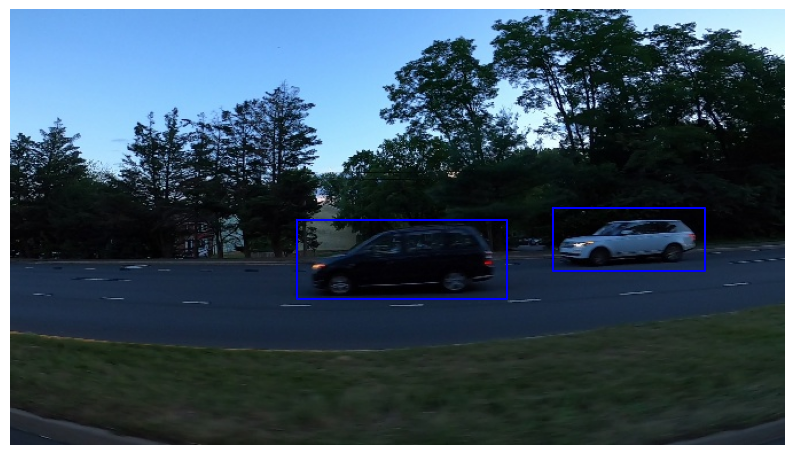

In [ ]:
import matplotlib.pyplot as plt

# Get image and image info from test set
img_id = 0
img, info = validation_dataset[img_id]
# Get bounding box coordinates
boxes = info['boxes']

plt.figure(figsize=(10,10))
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap="gray")
for x1,y1,x2,y2 in boxes.tolist():
  plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'b-')
plt.axis('off')
plt.show()


### f. Use data loaders


In this section, we instantiate data loaders that will be used to generate batches of images on the fly during training.

In [ ]:
from utils import collate_fn

torch.manual_seed(1)

data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=1,
    collate_fn=collate_fn)

val_data_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=4, shuffle=True, num_workers=1,
    collate_fn=collate_fn)

## Fast-RCNN fine-tuning





### a. Model's configuration
https://github.com/pytorch/vision/blob/master/torchvision/models/detection/faster_rcnn.py

Familiarize yourself with the various arguments of the **FasterRCNN** class.


1. Compute the images' means and std so that the model can perform input normalization with the image_mean and image_std arguments. The outputs of the functions should be tuples.

2. Compute the number of parameters in your model.

In [ ]:
from tqdm import tqdm_notebook as tqdm

def compute_means(dataset):
    return tuple(np.mean([np.mean(dataset[idx][0].numpy(), axis=(1,2)) for idx in tqdm(range(len(dataset)))], axis=0))

def compute_stds(dataset):
    return tuple(np.std([np.std(dataset[idx][0].numpy(), axis=(1,2)) for idx in tqdm(range(len(dataset)))], axis=0))

In [ ]:
image_mean = compute_means(train_dataset)
image_std = compute_stds(train_dataset)


print("Means: {}".format(image_mean))
print("Stds: {}".format(image_std))

<ipython-input-30-270804bd73d2>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  return tuple(np.mean([np.mean(dataset[idx][0].numpy(), axis=(1,2)) for idx in tqdm(range(len(dataset)))], axis=0))


  0%|          | 0/447 [00:00<?, ?it/s]

<ipython-input-30-270804bd73d2>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  return tuple(np.std([np.std(dataset[idx][0].numpy(), axis=(1,2)) for idx in tqdm(range(len(dataset)))], axis=0))


  0%|          | 0/447 [00:00<?, ?it/s]

Means: (0.23600695, 0.32598037, 0.36363333)
Stds: (0.019360386, 0.026706828, 0.049161825)


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,
#                                                             image_mean=image_mean,
#                                                             image_std=image_std)

model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True,
                                                             image_mean=image_mean,
                                                             image_std=image_std,
                                                             trainable_backbone_layers=3)
# replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 2  # car + background

# get number of input channels for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Number of trainable parameters: {:.4e}".format(params))

Number of trainable parameters: 1.8871e+07


In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Number of trainable parameters: {:.4e}".format(params))

Number of trainable parameters: 1.8871e+07


### Training



In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 2 classes only - background, cars
num_classes = 2
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.001,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate
# Change the scheduler type if you wish
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=10,
                                               gamma=0.5)

### b. Training and validation functions for on epoch.



In [ ]:
torch.__version__

'2.1.0+cu121'

In [ ]:
for i, values in enumerate(data_loader):
        images, targets = values
        images = list(image.float().to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        print(i, len(images), len(targets), targets)
        # Feed the training samples to the model and compute the losses
        loss_dict = model(images, targets)
        break

0 4 4 [{'boxes': tensor([[241., 181., 361., 227.],
        [480., 182., 575., 216.]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'image_id': tensor([390], device='cuda:0'), 'area': tensor([5520., 3230.], device='cuda:0'), 'iscrowd': tensor([0, 0], device='cuda:0')}, {'boxes': tensor([[ 50., 183., 116., 209.],
        [  0., 169.,  91., 211.]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'image_id': tensor([258], device='cuda:0'), 'area': tensor([1716., 3822.], device='cuda:0'), 'iscrowd': tensor([0, 0], device='cuda:0')}, {'boxes': tensor([[ 43., 195., 144., 233.],
        [188., 180., 300., 222.]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'image_id': tensor([292], device='cuda:0'), 'area': tensor([3838., 4704.], device='cuda:0'), 'iscrowd': tensor([0, 0], device='cuda:0')}, {'boxes': tensor([[615., 194., 676., 235.],
        [564., 195., 637., 227.],
        [406., 196., 498., 227.],
        [166., 188., 283., 233.],
        [ 45.

In [ ]:
loss_dict

{'loss_classifier': tensor(0.4191, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1407, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.2311, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0198, device='cuda:0', grad_fn=<DivBackward0>)}

- Implement your own training function for one epoch. Your function should output a dictionary containing the overall loss values computed during the epoch.
- Implement a similar function meant to compute the losses over the validation set (NB: no backprop)

In [ ]:
import math
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    for i, values in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
        images, targets = values
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Feed the training samples to the model and compute the losses
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        # #Reduce the values in the dictionary from all processes so that process with rank 0 has the reduced results.
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        # Pytorch function to initialize optimizer
        optimizer.zero_grad()
        # Compute gradients or the backpropagation
        losses.backward()
        # Update current gradient
        optimizer.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

        # Record losses to plot learning curves
        if i == 0:
            history = {key: val.cpu().detach() for key, val in loss_dict_reduced.items()}
            history['loss'] = losses_reduced.cpu().detach()
        else:
            for key, val in loss_dict_reduced.items():history[key] += val.cpu().detach()
            history['loss'] += losses_reduced.cpu().detach()
    return history

In [ ]:
def validate_one_epoch(model, data_loader, device=device, print_freq=100):
    #model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Validation: "
    for i, values in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
        images, targets = values
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses = sum(loss for loss in loss_dict_reduced.values())
        #losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        loss_value = losses_reduced.item()
        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)

        # Record losses to plot learning curves
        if i == 0:
            history = {key: val.cpu().detach() for key, val in loss_dict_reduced.items()}
            history['loss'] = losses_reduced.cpu().detach()
        else:
            for key, val in loss_dict_reduced.items():history[key] += val.cpu().detach()
            history['loss'] += losses_reduced.cpu().detach()
    return history

### c. Train your model

BONUS: use tensorboard to watch learning curves and predictions of bounding boxes evolve as you train your model.

In [ ]:
import utils

num_epochs = 10

for epoch in range(num_epochs):

    # Train for one epoch, printing every 10 iterations
    train_his_ = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)

    # Compute losses over the validation set
    val_his_ = validate_one_epoch(model, val_data_loader, device, print_freq=100)

    # Update the learning rate
    lr_scheduler.step()

    # Store loss values to plot learning curves afterwork.
    if epoch == 0:
        train_history = {k: [v] for k, v in train_his_.items()}
        val_history = {k: [v] for k, v in val_his_.items()}
    else:
        for k, v in train_his_.items():train_history[k] += [v]
        for k, v in val_his_.items():val_history[k] += [v]

    # Save the model if you wish. You can add a criteria before saving, for example
    # if the validation decreases.
    # save_path = "/content/drive/My Drive/mva_td/saved_models/my_model"
    # torch.save(model, save_path)

    torch.cuda.empty_cache()

Epoch: [0]  [  0/112]  eta: 0:02:01  lr: 0.001000  loss: 0.8708 (0.8708)  loss_classifier: 0.3756 (0.3756)  loss_box_reg: 0.0853 (0.0853)  loss_objectness: 0.3708 (0.3708)  loss_rpn_box_reg: 0.0390 (0.0390)  time: 1.0847  data: 0.1759  max mem: 3481
Epoch: [0]  [100/112]  eta: 0:00:02  lr: 0.001000  loss: 0.6497 (0.6173)  loss_classifier: 0.2159 (0.2234)  loss_box_reg: 0.4224 (0.3635)  loss_objectness: 0.0055 (0.0224)  loss_rpn_box_reg: 0.0062 (0.0079)  time: 0.1978  data: 0.0150  max mem: 3670
Epoch: [0]  [111/112]  eta: 0:00:00  lr: 0.001000  loss: 0.5895 (0.6209)  loss_classifier: 0.1814 (0.2221)  loss_box_reg: 0.3626 (0.3698)  loss_objectness: 0.0059 (0.0212)  loss_rpn_box_reg: 0.0050 (0.0078)  time: 0.1903  data: 0.0130  max mem: 3670
Epoch: [0] Total time: 0:00:24 (0.2180 s / it)
Validation:   [ 0/28]  eta: 0:00:06  loss: 0.8237 (0.8237)  loss_classifier: 0.2626 (0.2626)  loss_box_reg: 0.5193 (0.5193)  loss_objectness: 0.0351 (0.0351)  loss_rpn_box_reg: 0.0067 (0.0067)  time: 0.2

### d. Learning curves

Plot the learning curves using the train_history and val_history

Is your model overfitting ?



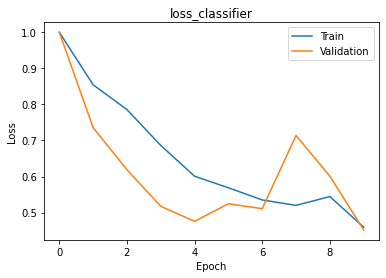

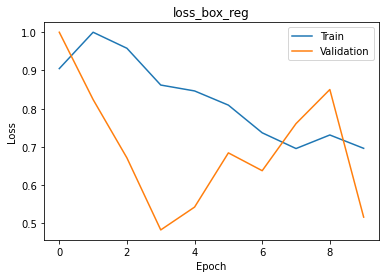

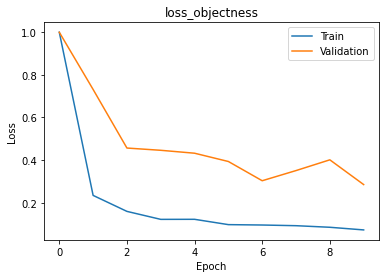

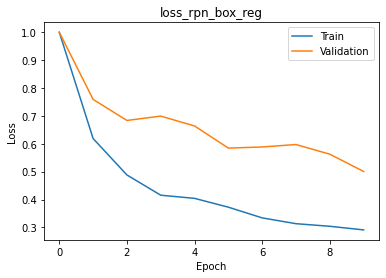

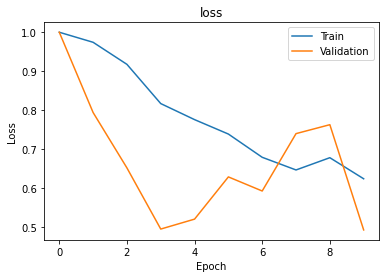

In [ ]:
for k in train_history:
    """ FILL HERE """
    plt.plot(np.arange(len(train_history[k]), dtype=int), train_history[k]/np.max(train_history[k]), label='Train')
    plt.plot(np.arange(len(val_history[k]), dtype=int), val_history[k]/np.max(val_history[k]), label='Validation')
    plt.title(k)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Inference time over the test set


### a. Keeping only the most relevant boxes : Non Maximum Suppression

1. Implement non max suppression to keep only non overlapping predicted bounding boxes.
2. Visualize effect of NMS on predictions

In [ ]:
def compute_iou(box, boxes, box_area, boxes_area):
    """Calculates IoU of the given box with the array of the given boxes.
    box: 1D vector [y1, x1, y2, x2]
    boxes: [boxes_count, (y1, x1, y2, x2)]
    box_area: float. the area of 'box'
    boxes_area: array of length boxes_count.
    Note: the areas are passed in rather than calculated here for
    efficiency. Calculate once in the caller to avoid duplicate work.
    """
    # Calculate intersection areas
    """ FILL HERE """
    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou

def non_max_suppression(boxes, scores, threshold):
    """Performs non-maximum suppression and returns indices of kept boxes.
    boxes: [N, (y1, x1, y2, x2)]. Notice that (y2, x2) lays outside the box.
    scores: 1-D array of box scores.
    threshold: Float. IoU threshold to use for filtering.
    """
    assert boxes.shape[0] > 0
    if boxes.dtype.kind != "f":
        boxes = boxes.astype(np.float32)

    """ FILL HERE """
    # Compute box areas
    y1 = boxes[:, 0]
    x1 = boxes[:, 1]
    y2 = boxes[:, 2]
    x2 = boxes[:, 3]
    area = (y2 - y1) * (x2 - x1)

    # Get indicies of boxes sorted by scores (highest first)
    ixs = scores.argsort()[::-1]

    pick = []
    while len(ixs) > 0:
        # Pick top box and add its index to the list
        i = ixs[0]
        pick.append(i)
        # Compute IoU of the picked box with the rest
        iou = compute_iou(boxes[i], boxes[ixs[1:]], area[i], area[ixs[1:]])
        # Identify boxes with IoU over the threshold. This
        # returns indices into ixs[1:], so add 1 to get
        # indices into ixs.
        remove_ixs = np.where(iou > threshold)[0] + 1
        # Remove indices of the picked and overlapped boxes.
        ixs = np.delete(ixs, remove_ixs)
        ixs = np.delete(ixs, 0)
    return np.array(pick, dtype=np.int32)


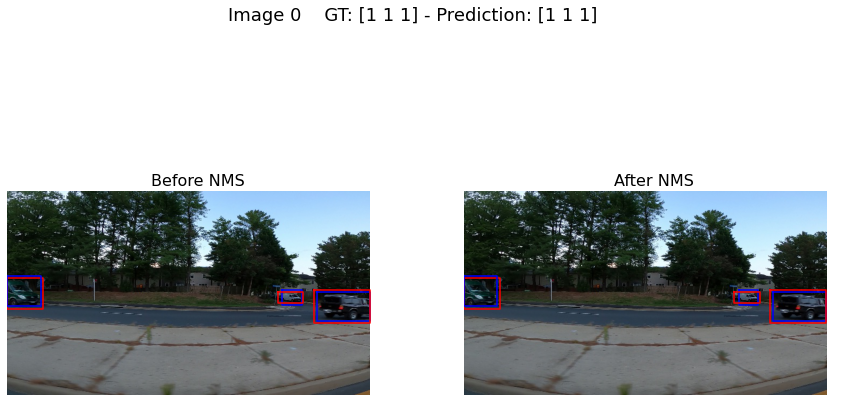

In [ ]:
# VISUALIZATION

# CHOOSE A THRESHOLD FOR NMS
threshold = 0.001


# Select image in test set
img, target = validation_dataset[100]
# Put model in evaluation mode
model.eval()
# Perform prediction
with torch.no_grad(): prediction = model([img.to(device)])

prediction = [{k:v.detach().cpu()for k,v in pred.items()} for pred in prediction]

# Retrieve ground-truth and predicted label
gt_label = target["labels"].cpu().numpy()
pred_label = target["labels"].cpu().numpy()

# Retrieve predicted bounding boxes and scores
boxes = prediction[0]['boxes'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Plot predicted bouding boxes before and after NMS
plt.figure(figsize=(15, 10))
plt.suptitle("Image {}    GT: {} - Prediction: {}".format(0, gt_label, pred_label), y=0.9, fontsize=18)
plt.subplot(121)
plt.title("Before NMS", fontsize=16)
plt.axis('off')
for i in range(len(boxes)):

    plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
    x1,y1,x2,y2 = target["boxes"][i]
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'b-')


    box_label = ["car" for i in range(len(target["labels"]))]

    x1,y1,x2,y2 = prediction[0]['boxes'][i]
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'r')


kept_boxes = non_max_suppression(boxes, scores, threshold)
plt.subplot(122)
plt.title('After NMS', fontsize=16)
plt.axis('off')
for i in kept_boxes:

    plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
    x1,y1,x2,y2 = target["boxes"][i]
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'b-')

    box_label = ["car" for i in range(len(kept_boxes))]

    x1,y1,x2,y2 = prediction[0]['boxes'][i]
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'r')
plt.show()

### c. Evaluation metrics

1. Implement accuracy.

In [ ]:
def accuracy(gt_labels, pred_labels):
    """
    Calculate the accuracy of predicted labels.

    Parameters:
        gt_labels (torch.Tensor): Tensor of ground truth labels.
        pred_labels (torch.Tensor): Tensor of predicted labels.

    Returns:
        float: Accuracy of the prediction.
    """
    # Convert tensors to numpy arrays
    gt_labels = gt_labels.cpu().numpy()
    pred_labels = pred_labels.cpu().numpy()

    # Calculate accuracy
    correct = (gt_labels == pred_labels).sum().item()
    total = len(gt_labels)
    acc = correct / total if total != 0 else 0
    return acc

2. Implement the F1-score metric to evaluate the model's classification performance.



In [ ]:
def f1_score(gt_labels, pred_labels, epsilon=1e-7):
    """
    Calculate the F1 score of predicted labels.

    Parameters:
        gt_labels (torch.Tensor): Tensor of ground truth labels.
        pred_labels (torch.Tensor): Tensor of predicted labels.
        epsilon (float, optional): A small value to prevent division by zero.

    Returns:
        float: F1 score of the prediction.
    """
    # Convert tensors to numpy arrays
    gt_labels = gt_labels.cpu().numpy()
    pred_labels = pred_labels.cpu().numpy()

    # Calculate true positives, false positives, and false negatives
    true_positives = ((gt_labels == 1) & (pred_labels == 1)).sum()
    false_positives = ((gt_labels == 0) & (pred_labels == 1)).sum()
    false_negatives = ((gt_labels == 1) & (pred_labels == 0)).sum()

    # Calculate precision, recall, and F1 score
    precision = true_positives / (true_positives + false_positives + epsilon)
    recall = true_positives / (true_positives + false_negatives + epsilon)
    f1_ = 2 * (precision * recall) / (precision + recall + epsilon)

    return f1_


3. Implement your own IoU to evaluate bounding box regression.


In [ ]:
def IoU(boxA, boxB):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.

    Parameters:
        boxA (torch.Tensor): Tensor representing the first bounding box in format [x1, y1, x2, y2].
        boxB (torch.Tensor): Tensor representing the second bounding box in format [x1, y1, x2, y2].

    Returns:
        float: Intersection over Union (IoU) score.
    """
    # Determine the coordinates of the intersection rectangle
    xA = torch.max(boxA[0], boxB[0])
    yA = torch.max(boxA[1], boxB[1])
    xB = torch.min(boxA[2], boxB[2])
    yB = torch.min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    intersection = torch.max(torch.zeros(1, dtype=boxA.dtype, device=boxA.device), xB - xA) * torch.max(torch.zeros(1, dtype=boxA.dtype, device=boxA.device), yB - yA)

    # Compute the area of both the prediction and ground-truth rectangles
    area_A = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_B = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the union
    union = area_A + area_B - intersection

    # Compute IoU
    iou = intersection / union

    return iou


4. Compare metrics when the model is evaluated on the train set and the test set

In [ ]:
def evaluate(model, dataset, device):
    """
    Ths function evaluates the model on dataset
    using the previous metrics, accuracy, f1_score, and IoU
    """

    # Put the model in evaluation mode
    model.eval()

    gt_labels, pred_labels = np.array([]), np.array([])
    gt_boxes, pred_boxes = np.empty(4), np.empty(4)
    for idx in tqdm(dataset.img_dict):
        img, target = dataset[idx]
        with torch.no_grad(): prediction = model([img.to(device)])

        gt_labels = np.concatenate([gt_labels, np.array([target['labels'].item()])], axis=-1)
        pred_labels = np.concatenate([pred_labels, np.array([prediction[0]["labels"][0].item()])], axis=-1)

        gt_boxes = np.vstack((gt_boxes, target['boxes'][0]))
        pred_boxes = np.vstack((pred_boxes, prediction[0]['boxes'][0].cpu()))

    f1 = f1_score(gt_labels, pred_labels)
    print("F1_score over {} set: {:.2f}".format(dataset.name, f1))
    average_iou = np.mean([IoU(gt_boxes[i], pred_boxes[i]) for i in range(len(gt_boxes))])
    print("Average IoU over {} set: {:.2f}".format(dataset.name, average_iou))
    acc = accuracy(gt_labels, pred_labels)
    print('Accuracy over {} set: {:.3f}'.format(dataset.name, acc))

In [ ]:
evaluate(model, train, device)
evaluate(model, test, device)

### d. Evaluation based on COCO mAP

Use the `evaluate` function from `engine` that computes mAP metrics at different thresholds.

see code : `https://github.com/pytorch/vision/blob/main/references/detection/engine.py`



In [ ]:
from engine import evaluate
evaluate(model, val_data_loader, device)

creating index...
index created!
Test:  [ 0/28]  eta: 0:00:19  model_time: 0.5246 (0.5246)  evaluator_time: 0.0043 (0.0043)  time: 0.6816  data: 0.1474  max mem: 9653
Test:  [27/28]  eta: 0:00:00  model_time: 0.5117 (0.5097)  evaluator_time: 0.0033 (0.0037)  time: 0.5397  data: 0.0179  max mem: 9653
Test: Total time: 0:00:15 (0.5425 s / it)
Averaged stats: model_time: 0.5117 (0.5097)  evaluator_time: 0.0033 (0.0037)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.170
 Average Recall     (AR) @[ IoU=

In [ ]:
from engine import evaluate
evaluate(model, data_loader, device)

creating index...
index created!
Test:  [  0/112]  eta: 0:01:16  model_time: 0.5286 (0.5286)  evaluator_time: 0.0033 (0.0033)  time: 0.6843  data: 0.1473  max mem: 9653
Test:  [100/112]  eta: 0:00:06  model_time: 0.5012 (0.5135)  evaluator_time: 0.0035 (0.0038)  time: 0.5308  data: 0.0189  max mem: 9653
Test:  [111/112]  eta: 0:00:00  model_time: 0.4969 (0.5106)  evaluator_time: 0.0034 (0.0039)  time: 0.5180  data: 0.0175  max mem: 9653
Test: Total time: 0:01:00 (0.5398 s / it)
Averaged stats: model_time: 0.4969 (0.5106)  evaluator_time: 0.0034 (0.0039)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med